# 2. Responses to Stimuli and Deriving Metrics

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. **[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)**
3. *[Canonical Models](3_Basics_CanonModels.ipynb)*
4. *[Comparing Networks](4_UseCase_CompareNets.ipynb)*
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_Basics_WeightedNets.ipynb)* 

---------------------

### Outline and functions used in this notebook

1. Understanding *pair-wise* responses
    * Pair-wise response matrices and temporal curves.
    * Stimuli are independent, so are the responses elicited.
    * Total responses (accumulated influence over time).
2. Evaluating and interpreting *node-wise* responses.
    * In-/out-node properties. Relation to node degree.
    * Self-responses and recurrence of stimulus.
3. *Global* network response.

Main *SiReNetA* functions studied:
* `Resp_LeakyCascade()` : xxxxxxxx.
* `AreaUnderCurve()` : xxxxxx
* `GlobalResponse()`: evaluation of whole network effect resulting from stimulation
* `NodeResponses()`: evaluation of broadcasting and receiving properties of nodes

---------------------

### Before begining, import the libraries we will need

In [1]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg

# Import SiReNetA
import sireneta as sna


In [2]:
# Define plotting options to control visualization
%matplotlib inline

# Load the options from a local file
from plot_specs import *

In [ ]:
# Visualise the colormaps added, if wanted
#new_bwr
#new_Reds
#new_Blues

---------------
## 2.1. Understanding the *pair-wise* responses
<!---
The aim of *Response Network Analysis (SRNA)* is to characterise the properties of complex networks from a dynamical perspective, alternatively to the combinatorial or probabilistic approach of classical graph theory. Under *SRNA* the observed network properties depend both on the structural connectivity (adjacency matrix *A*) but also on the rules governing how agents, particles or signals propagate along the network. Accordingly, the same connectivity may reveal different properties under different propagation paradigms.
--->

The core idea behind *SRNA* is to reveal the properties of networks by probing them via localised perturbations. A stimulus of unit amplitude applied at node *j* at time *t = 0* elicits responses $\mathcal{R}_{ij}(t)$ at all other nodes *i* over time. The pair-wise response, from *j* to *i*, is the result of the stimulus propagating over all possible routes, of all lengths, at different times. Hence, in *SRNA* the spatio-temporal response matrices $\mathcal{R}_{ij}(t)$ contain all the necessary information to characterise the network (jointly with its dynamics). 

<!---
>Graph analysis : Connectivity matrix *A*   ––>   probabilistic metrics.

>SRNA :  Connectivity matrix *A* + canonical propagation model  ––>  $\mathcal{R}_{ij}(t)$  ––>  spatio-temporal metrics.
REPLACE THIS BY A FIGURE !!
--->

Consider the small network below. We apply a unit stimulus at the first *j = 1* initially at time *t = 0* and observe the responses elicited on the other nodes, as the activity propagates along the chain.

<img src="img/PathDigraph1.jpg"  width="400" alt="Path Digraph, stim j=1" />

We will also assume the activity propagates following the *leaky-cascade* canonical propagation model:

$$\dot{\mathbf{x}}(t) = - \frac{1}{\tau} \mathbf{x}(t) \,+\, A \, \mathbf{x}(t) $$

where $\mathbf{x}(t)$ is are the *N* signals and $\tau$ is a leakage time-constant controlling for the dissipation rate. See [xxxxx](#) for the details of the model.


To compute the response matrices of the matrix we will: 
* Load the adjacency matrix from a file (`net1`),
* Set the simulation parameters:
    * Duration (`tfinal`).
    * Simulation time step (`dt`).
    * Set the leakage time-constant (`tau`).
* Define the stimulus amplitudes (`stimvec`). 

To apply a stimulus only to the first node, `stimvec` is defined as an empty 1D array of length *N*, and only the first entry is set to 1.0.


In [3]:
#  Load the directed path graph from a file
A1 = np.loadtxt('../Data/Testnet_PathDigraph_N6.txt', dtype=int)
N = len(A1)


In [4]:
# Define the simulation parameters
# Set the temporal resolution
tfinal = 12
dt = 0.01
tpoints1 = np.arange(0.0, tfinal+dt, dt)
nsteps1 = len(tpoints1)

# Set the leakage time-constants τ
tau = 1.0

# Define the stimulation amplitude to every node
# In this example, only the first node is stimulated
stimvec = np.zeros(N)
stimvec[0] = 1.0


### Pair-wise responses

Now, we compute and visualize the pair-wise responses $\mathcal{R}_{ij}(t)$ over time. The result `R1` is a 3D array of shape (nsteps, N,N), with the temporal dimension along the first axis. `nsteps` is the number of time samples of the simulation.

> _**ACHTUNG !!**_ *SiReNetA* follows the dynamical systems convention for which $A_{ij} = 1$ means a link from *j* to *i*. This is contrary to the convention in graph theory that would consider $A_{ij} = 1$ for a link from *i* to *j*. Therefore, the transpose of the adjacency matrix `net1.T` is passed to the function calculating the response matrices `sna.Resp_LeakyCascade()`.

In [5]:
# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R1 = sna.Resp_LeakyCascade(A1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()

print( f'{time2 - time1:3.4f} seconds' )
print( f'Shape of R1: {R1.shape}' )

0.4056 seconds
Shape of R1: (1201, 6, 6)


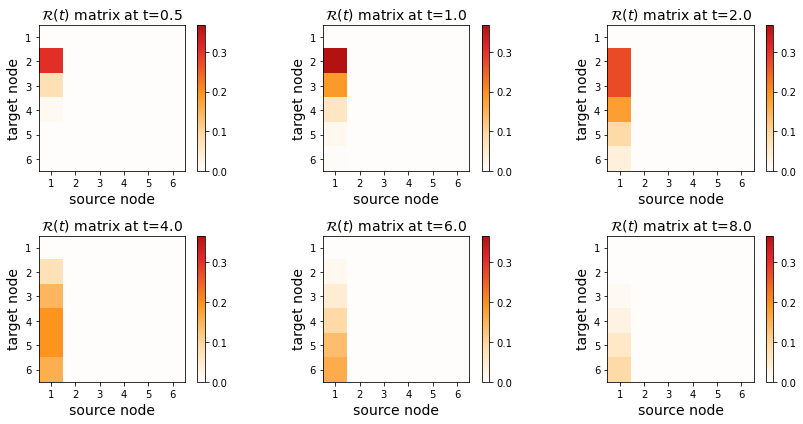

In [6]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R1.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R1[tidx], cmap=new_Reds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

These matrices show the propagation of the stimulus to the nodes down the chain. Notice that for all $j \geq 2$, the values (columns) $\mathcal{R}_{ij}(t) = 0$ because no stimulus was applied at them. 
Now, let's visualize some specific response curves over time, e.g., the responses of all the nodes

- to the stimulus at *j = 1*, and
- to the (absence of) stimulus at *j = 2*.


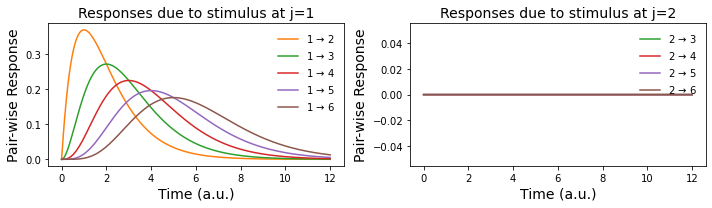

In [6]:
plt.figure(figsize=(10,3))

# Plot the responses to the stimulus applied at j = 1.
plt.subplot(1,2,1)
jstim=0
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(1,N):
    plt.plot(tpoints1, R1[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

# Plot the responses to the stimulus applied at j = 2.
plt.subplot(1,2,2)
jstim=1
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(2,N):
    plt.plot(tpoints1, R1[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

plt.tight_layout()

As a result of the initial stimulus applied at *j=1*, the responses of nodes down the directed chain (left panel) display both a subsequent delay and a decreased peak response. However, (right panel) since no stimulus was initially applied at *j=2*, no responses are measured in the rest of the nodes. 

This simple example helps illustrating two relevant lessons for the correct interpretation of the information encoded in $\mathcal{R}_{ij}(t)$: 

- LESSON 1: The response of node *i* is _**conditional to the stimulus**_ applied at *j*. That is, a response $\mathcal{R}_{ij}(t) > 0$ can be observed at node *i* only if there was a stimulus at node *j*. If no stimulus is applied at *j*, then no response is elicited on the other nodes and $\mathcal{R}_{ij}(t) = 0$.
- LESSON 2: Despite the responses are evaluated in a pair-wise fashion, from *j* to *i*, $\mathcal{R}_{ij}(t)$ is the result of the stimulus applied at *j* _**propagating throughout the whole network**_, and affecting node *i* over all possible paths of all lengths at different times, beyond direct connections.

For example, the curve $\mathcal{R}_{61}(t)$ shown above (brown curve, left panel) is the response we observe at node *i=6* to the stimulus applied at *j=1* (and only at *j=1*) after this has propagated through nodes *2* to *5* before reaching *i=6*. Consequently, despite the "interaction" from *1* to *6* arrives at *i=6* through the link $5 \to6$, the responses $\mathcal{R}_{65}(t) = 0$ because no input was applied at node *5*.


### Stimuli are independent, so are the responses elicited

A consequence of the two points just raised is that, currently in *SRNA*, stimuli applied at different nodes elicit independent responses. Even if the matrices $\mathcal{R}_{ij}(t)$ are evaluated simultaneously for all inputs, the result is the same as if the input to each node was evaluated separately, one after another.

To illustrate this better we now apply two initial stimuli at *j=1* and *j=4* and re-evaluate the pair-wise response matrices.

<img src="img/PathDigraph3.jpg"  width="400" alt="Path Digraph, stim j=1 and j=3" />

In [8]:
# Define the stimulation amplitude to every node
# Unit stimulus is applied at two different nodes.
stimvec = np.zeros(N)
stimvec[0] = 1.0
stimvec[2] = 1.0

# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R2 = sna.Resp_LeakyCascade(A1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()
print( f'{time2 - time1:3.4f} seconds' )

print( f'Shape of R2: {R2.shape}' )


0.3588 seconds
Shape of R2: (1201, 6, 6)


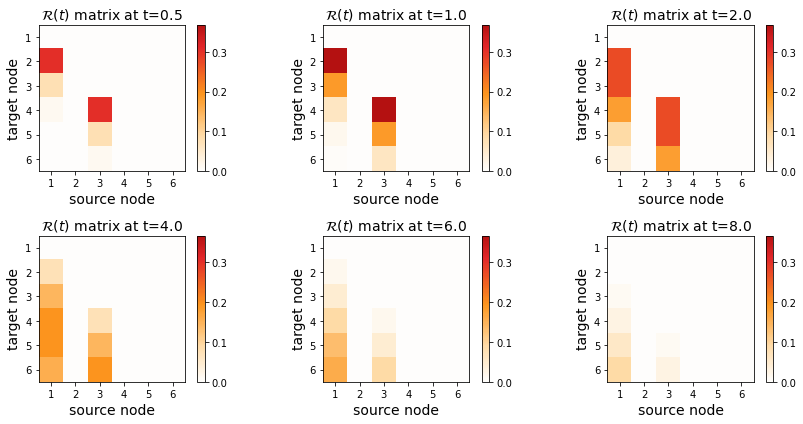

In [9]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R2.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R2[tidx], cmap=new_Reds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

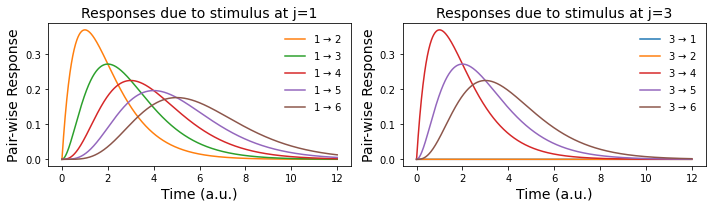

In [10]:
plt.figure(figsize=(10,3))

# Plot the responses to the stimulus applied at j = 1.
plt.subplot(1,2,1)
jstim=0
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(1,N):
    plt.plot(tpoints1, R2[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

# Plot the responses to the stimulus applied at j = 3.
plt.subplot(1,2,2)
jstim=2
plt.title( f'Responses due to stimulus at j={jstim+1}', fontsize=14)
for i in range(N):
    if i==jstim: continue
    plt.plot(tpoints1, R2[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

plt.tight_layout()

The responses to the stimulus at *j=1* are exactly the same as before while now the matrices $\mathcal{R}_{ij}(t)$ also contain the nonzero responses of nodes *4, 5* and *6* to the input at *j=3*. Responses $3 \to 1$ and $3 \to 2$ are zero because in the directed chain no path exists that would allow the stimulus to travel backwards.

### Total responses 

We can reduce the influence that a node exerts over another into a single number by evaluating the accumulated response over time. Formally, the total response $\bar{\mathcal{R}}_{ij}$ from *j* to *i* is computed as the integral (or area-under-curve) of the pair-wise response:

$$ \bar{\mathcal{R}}_{ij} = \int_{t=0}^{t'} \mathcal{R}_{ij}(t) \, dt \; ,$$  

where $t'$ is an arbitrary time point. For the leaky-cascade canonical propagation model, this should be considered as the convergence time $t' = \infty$, as illustrated in the figure below. See [xxxxxx](#) for choices in other canonical models. 

<img src="img/AuC_Example.jpg"  width="350" alt="Area Under Curve" />

In *SiReNetA*, total responses are evaluated with the function `sna.AreaUnderCurve()`. For 3D tensors like `R1`or `R2`, the function returns a matrix of shape $N \times N$.



Shape of totR2: (6, 6)


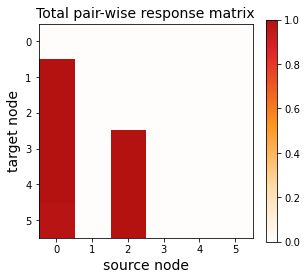

In [46]:
# Compute and visualise the total response matrix
totR2 = sna.AreaUnderCurve(R2,dt)
print( f'Shape of totR2: {totR2.shape}')

# Visualize the matrix
plt.figure(figsize=(4.8,4))
plt.title( 'Total pair-wise response matrix' )
plt.imshow(totR2, cmap=new_Reds)
plt.colorbar()
plt.clim(0,1)

plt.xlabel( 'source node' );
plt.ylabel( 'target node' );



In this case, due to the trivial architecture of the directed chain, all total pair-wise responses are either 0 or 1.0. Which shows that, despite the individual curves for $\mathcal{R}_{i1}(t)$ displayed a unique shape of different time-delays and peak amplitudes, overall, the unit stimulus applied at *j=1* leads to a total unit response over time, at all nodes.

------------------


## 2.2.  Evaluating and interpreting the *node-wise* responses


CONTINUE HERE !!
- In-/out node responses $r_i^-(t)$ and $r_i^+(t)$. 
    - Interpretation, 
    - Relation with each other,
- Self-responses, 
    - definition / distribution.
    - Relation to clustering coefficient !?


In order to illustrate the extraction and analysis of node-wise responses, we will employ the directed graph of *N = 8* nodes illustrated below:

<img src="img/TestNet_N8_D1.jpg"  width="220" alt="TestNet N8, directed" />

In [12]:
#  Load the new test digraph from a file
A3 = np.loadtxt('../Data/Testnet_N8_D.txt', dtype=int)
N = len(A3)

# Calculate the input and output degrees
ink = A3.sum(axis=0)
outk = A3.sum(axis=1)

print( f'input degrees  : {ink}')
print( f'output degrees : {outk}')

#print(A3)

input degrees  : [1 1 1 4 1 4 1 1]
output degrees : [1 2 2 3 1 2 1 2]


The network is directed. Nodes 3 and 4 have different in- / out-degrees.

We now estimate the pair-wise response tensor for this network. Before, we need to estimate its largest possible leakage time-constant $\tau$.

In [13]:
# Find the largest eigenvalue of the connectivity matrix A
evs = np.linalg.eigvals(A3)
evmax = evs.real.max()
# Calculate the largest possible tau
taumax = 1.0 / evmax

print( f'Spectral radius:     \t{evmax:2.5f}' )
print( f'Largest possible tau:\t{taumax:2.5f}' )


Spectral radius:     	1.90281
Largest possible tau:	0.52554


In [14]:
# Define the simulation parameters
# Set the temporal resolution
tfinal3 = 5
dt3 = 0.001
tpoints3 = np.arange(0.0, tfinal3+dt3, dt3)
nsteps3 = len(tpoints3)

# Set the leakage time-constants τ
tau3 = 0.6 * taumax

# Define the stimulation amplitude to every node
# Now we apply stimulus to all nodes
stimvec3 = np.ones(N)


In [15]:
# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R3 = sna.Resp_LeakyCascade(A3.T, S0=stimvec3, tau=tau3, tmax=tfinal3, timestep=dt3)
time2 = timer()
print( f'{time2 - time1:3.4f} seconds' )

print( f'Shape of R3: {R3.shape}' )

1.5252 seconds
Shape of R3: (5001, 8, 8)


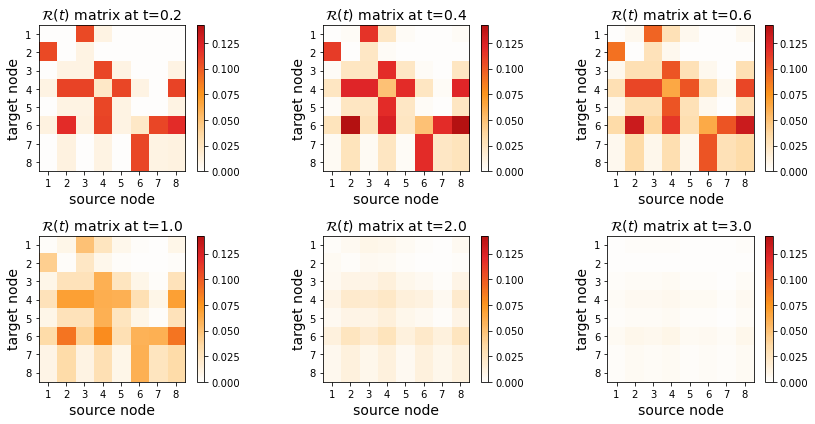

In [16]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp3 = R3.max()

tidxlist = [200,400,600,1000,2000,3000]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints3[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R3[tidx], cmap=new_Reds)
    plt.clim(0,maxresp3)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

### Input / output node properties: broadcasting vs. response

Definition of input and output responses $r_i(t)$, plust some illustration 


<img src="img/NodeResp_Illustration.jpg"  width="700" alt="In-/out-node responses" />



For this, move to the directed TestNet_N8, and add stimulus in all nodes. Show 

- response matrices,
- in / out responses,
- Global network response.

Mention function `sna.NodeResponses()`. Its parameters and output.

Mention function `sna.AreaUnderCurve()` now returns a vector.


In [17]:
# Calculate the in-/out- responsesefull-flow for every node
# in- and out-responses for every node
inr_nodes, outr_nodes = sna.NodeResponses(R3, selfresp=True)

print(inr_nodes.shape)

totinr_nodes = sna.AreaUnderCurve(inr_nodes,dt3)
totoutr_nodes = sna.AreaUnderCurve(outr_nodes,dt3)

# CLEAN THIS !!
print( totinr_nodes.shape )
print( totinr_nodes )
print( totoutr_nodes )


(5001, 8)
(8,)
[0.20949099 0.16536443 0.34977735 0.79533205 0.34977735 0.95097011
 0.39870565 0.39870565]
[0.2760792  0.56136714 0.50611576 0.70029375 0.31982288 0.45153347
 0.24154426 0.56136714]


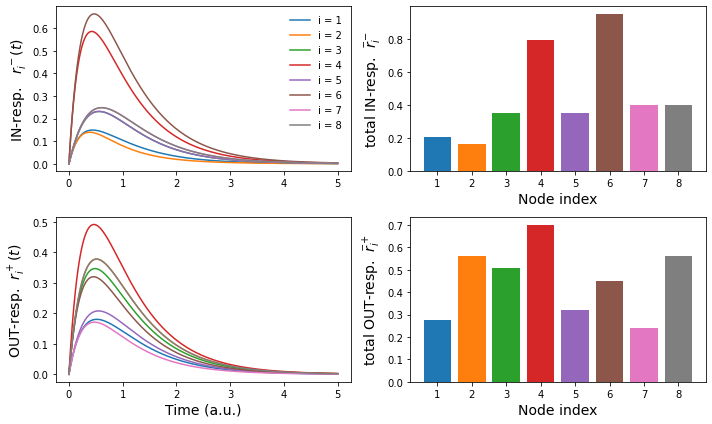

In [18]:
# Plot a figure with the input and output responses of every node
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
#plt.title('Response for every node', fontsize=14)
for i in range(N):
    plt.plot(tpoints3, inr_nodes[:,i], label=f'i = {i+1}')
#plt.ylim(-0.005,0.1)
plt.legend()
plt.ylabel( 'IN-resp.   $r^-_i(t)$' );

plt.subplot(2,2,3)
for i in range(N):
    plt.plot(tpoints3, outr_nodes[:,i], label=f'i = {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'OUT-resp.  $r^+_i(t)$' );


plt.subplot(2,2,2)
for i in range(N):
    plt.bar(i+1,totinr_nodes[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total IN-resp.  $\\widebar{r}^-_i$' );

plt.subplot(2,2,4)
for i in range(N):
    plt.bar(i+1,totoutr_nodes[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total OUT-resp.  $\\widebar{r}^+_i$' );


plt.tight_layout()

COMMENT SOMETHING HERE …

For larger networks we would display the degree distributions, more than the degrees themselves.

More clearly, we can visually we compare the in-/out-responses of each node.

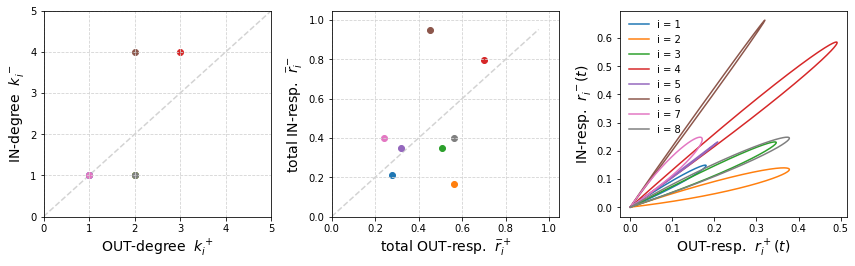

In [19]:
# Compare the in- / out- responses for every node
plt.figure(figsize=(12,3.8))

# The classical node degrees
plt.subplot(1,3,1)
for i in range(N):
    plt.scatter(outk[i],ink[i], label=f'i = {i+1}')
plt.plot((0,6),(0,6), ls='--', color='lightgray', zorder=0)
plt.grid(ls='--', color='lightgray')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel( 'OUT-degree  $k^+_i$' );
plt.ylabel( 'IN-degree  $k^-_i$' );

# Total in-/out-responses
maxtotr = max(totinr_nodes.max(),totoutr_nodes.max())
plt.subplot(1,3,2)
for i in range(N):
    plt.scatter(totoutr_nodes[i],totinr_nodes[i], label=f'i = {i+1}')
plt.plot((0,maxtotr),(0,maxtotr), ls='--', color='lightgray', zorder=0)
plt.grid(ls='--', color='lightgray')
plt.xlim(0,(1+0.1)*maxtotr)
plt.ylim(0,(1+0.1)*maxtotr)
plt.xlabel( 'total OUT-resp.  $\\widebar{r}^+_i$' );
plt.ylabel( 'total IN-resp.  $\\widebar{r}^-_i$' );

# Trayectories of in-/out responses over time
plt.subplot(1,3,3)
for i in range(N):
    plt.plot(outr_nodes[:,i], inr_nodes[:,i], label=f'i = {i+1}')
plt.xlabel( 'OUT-resp.  $r^+_i(t)$' );
plt.ylabel( 'IN-resp.  $r^-_i(t)$' );
plt.legend(loc='upper left')


plt.tight_layout()

COMMENT SOMETHING HERE  ...

The responses give a richer information than the degrees alone, although they are related. Despite only *i=3* and *i=4* have unbalanced degrees, in terms of the dynamical propagation, the in-/out-responses

Remind interpretations of influence/broadcasting and slave/receiving/integration

### Self-responses

Write me here ... It can be considered a generalization of the clustering coefficient ...

We left undiscussed the response of a node to the initial stimulus on itself. So we define the self-response of a node as the diagonal entries of the pair-wise response matrices such that $r^o_i(t) \equiv \mathcal{R}_{ii}(t)$.

In [38]:
# Compute the response of every node to the input on itself
selfr = sna.SelfResponses(R3)

totselfr = sna.AreaUnderCurve(selfr, dt3)


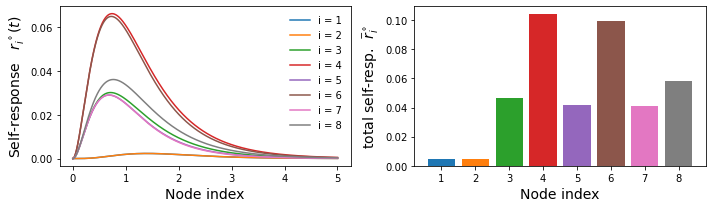

In [40]:
# Plot a figure with the input and output responses of every node
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)

for i in range(N):
    plt.plot(tpoints3, selfr[:,i], label=f'i = {i+1}')
plt.legend()
plt.ylabel( 'Self-response   $r^\circ_i(t)$' );
plt.xlabel( 'Node index' );

plt.subplot(1,2,2)
for i in range(N):
    plt.bar(i+1,totselfr[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total self-resp.  $\\widebar{r}^\circ_i$' );

plt.tight_layout()


COMMENT HERE ...

1 and 2 feel receive their stimuli only via a unique cycle of length 4:

* 1 $\to$ 2 $\to$ 3 $\to$ 1, and 
* 2 $\to$ 3 $\to$ 1 $\to$ 2. 
    
Therefore their very small self-responses.


---------------------

## 2.3. Global network responses

- Global response, $r(t)$ and its integral $\bar{r}(t)$.
- Relation to the pair-wise and node-wise response sums.
- Global self-responses $r^o(t)$ $r^\circ(t)$ (sum of all node-wise self-responses).
- Diversity of pair-wise patterns (?).

So far, we have 

UNDER CONSTRUCTION … STILL TESTING !!

In [20]:
# Compute the global network response
globR3 = sna.GlobalResponse(R3)

# Compute the total response for the global one 
totglobR3 = sna.AreaUnderCurve(globR3,dt3)

# Validate that total network response equal the sum of total node responses
print( f'Total network response, from global response:\t {totglobR3:3.4f}' )
print( f'Total network response, sum of node responses:\t {totinr_nodes.sum():3.4f}' )

Total network response, from global response:	 3.6181
Total network response, sum of node responses:	 3.6181


Compare the global response to that of randomised networks.

In [21]:
import sireneta.netmodels

In [22]:

nrealiz = 10
globRlist = np.zeros((nrealiz,nsteps3), float64)
totRlist = np.zeros((nrealiz), float64)

print( f'Calculating responses for {nrealiz} randomised networks ...' )
time1 = timer()
for re in range(nrealiz):
    # Generate a randomised network
    randA = sna.netmodels.ShuffleLinks(A3)

    # Calculate temporal evolution of the pair-wise responses R(t)
    randR = sna.Resp_LeakyCascade(randA.T, S0=stimvec3, tau=tau3, tmax=tfinal3, timestep=dt3)
    
    globRlist[re] = sna.GlobalResponse(randR)
    totRlist[re] = sna.AreaUnderCurve(globRlist[re], dt3)

    del randR

time2 = timer()
print( f'{time2-time1} seconds' )

    

Calculating responses for 10 randomised networks ...
14.955499808000013 seconds


Total network response, orig:	 3.6181
Total network response, rand:	 2.8791 +- 0.3532


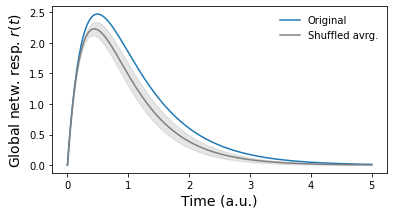

In [37]:
av_gr = globRlist.mean(axis=0)
std_gr = globRlist.std(axis=0)

plt.figure(figsize=(6,3))
plt.plot(tpoints3,globR3, label='Original')
plt.plot(tpoints3,av_gr, color='gray', label='Shuffled avrg.')
plt.fill_between(tpoints3,av_gr+std_gr,av_gr-std_gr, color='gray', alpha=0.2)

plt.legend()
plt.xlabel( 'Time (a.u.)' )
plt.ylabel( 'Global netw. resp. $r(t)$')
#plt.xlim(1,1.1)


# Compare the total network response between the original A3 digraph
# and in the randomized ones.
print( f'Total network response, orig:\t {totglobR3:3.4f}' )
print( f'Total network response, rand:\t {totRlist.mean():3.4f} +- {totRlist.std():3.4f}' )


Conclusions …

Where to go from here …